Demo notebook for augmenting diffraction patterns using the quantem/core/utils/DPAugmentor

Arthur McCray  
Last remembered to update this line: July 6, 2025

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from pathlib import Path

import numpy as np
import quantem as em
from quantem.core import config
from quantem.core.utils.augment_dp import DPAugmentor
from quantem.core.visualization import show_2d

GPU_IND = XXX
config.set({"device": f"cuda:{GPU_IND}"})
print(config.get("device"))


cuda:1


In [3]:
f_data = Path("~/data/example_data/polycrystal_2D_WS2.h5").expanduser()
print(f_data.exists())

True


keys:  ['4DSTEM', 'datacube', 'data']
(128, 128, 128, 128)


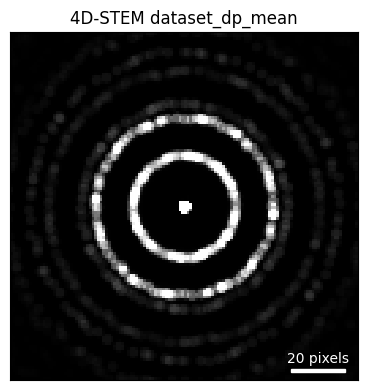

In [4]:
dset = em.io.read_emdfile_to_4dstem(str(f_data), data_keys=["4DSTEM", "datacube", "data"], calibration_keys=["4DSTEM", "datacube", "calibration"])
dset.units = ['pixels'] * 4 
dset.sampling = [1]*4
dset.get_dp_mean()
dset.get_dp_max()
dset.dp_mean.show()
print(dset.shape)

Hopefully this is pretty self explanatory. Each of the noise/augmentations can be enabled/disabled individually, and either a single value or range of values can be passed. E.g. if wanting to add random shifts, set `add_shift=True` and you could set `xshift=5` (each image will have a fixed shift of 5 pixels) and `yshift = [0,10]` (each image will have a randomly chosen y shift between 0 and 10 pixels, positive or negative). 

Passing a filepath to `log_file` will record, for each image, each of the augmentation parameters used. 

For the elastic transformations, i.e. shifts, ellipticity and scaling, non-90 degree rotations, you can have regions of your augmented image that are not in the field of view of the input. Setting your scale_factor to be minimum of 1 will help this, but it can still happen at the corners due to elliptic distortions, and free rotations also will lead to this. Regions outside the fov are just set to 0. 

Note that the default for `add_elipticity_to_label` is `True`, meaning that any elliptical distortions applied to the diffraction pattern will be applied to the label as well. I'm not sure if it will be possible for a NN to learn how to undo elliptical/scaling distortions, (probably not for scaling, hopefully for elliptical) hence why this is a flag. 

In [5]:
?DPAugmentor

Init signature:
DPAugmentor(
    add_bkg: bool = False,
    bkg_weight: list[float] | float = [0.001, 0.05],
    bkg_q: list[float] | float = [0.01, 0.1],
    add_shot: bool = False,
    e_dose: list[float] | float = [10000.0, 10000000.0],
    add_shift: bool = False,
    xshift: list[float] | float = [0, 10],
    yshift: list[float] | float = [0, 10],
    add_ellipticity: bool = False,
    ellipticity_scale: list[float] | float = [0, 0.15],
    add_ellipticity_to_label: bool = True,
    add_salt_and_pepper: bool = False,
    salt_and_pepper: list[float] | float = [0, 0.0005],
    add_scale: bool = False,
    scale_factor: list[float] | float = [0.9, 1.1],
    add_blur: bool = False,
    blur_sigma: list[float] | float = [0.0, 1.5],
    add_flipshift: bool = False,
    free_rotation: bool = False,
    rotation_range: list[float] | float = [-180, 180],
    log_file: os.PathLike | None = None,
    rng: numpy.random._generator.Generator | int | None = None,
    device: str = 'cpu',
)
Docs

Augmentation summary:
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Inelastic background: True
	Weight: 0.041, Q: 0.049
Shot noise: True
	e-dose: 8.73e+04
Image shift: True
	(x,y): (-9.76, -7.86)
Elliptic scaling: True
	(exx,eyy,exy): (0.98,1.02,0.01)
Scaling: True
	Factor: 0.95
Flip/rotation: True
	Flip: H=False, V=False, Rot: -20.4°
Salt & pepper: True
	Amount: 3.49e-04
Gaussian blur: True
	Sigma: 0.14
Random seed: 42
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


(<Figure size 800x400 with 4 Axes>,
 array([<Axes: title={'center': 'augmented image'}>,
        <Axes: title={'center': 'augmented label'}>], dtype=object))

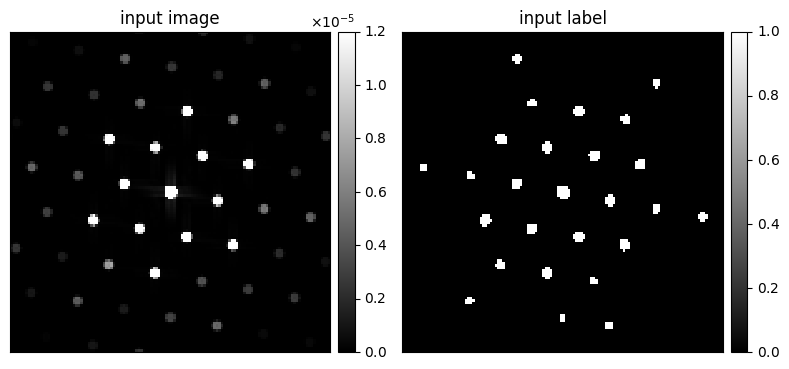

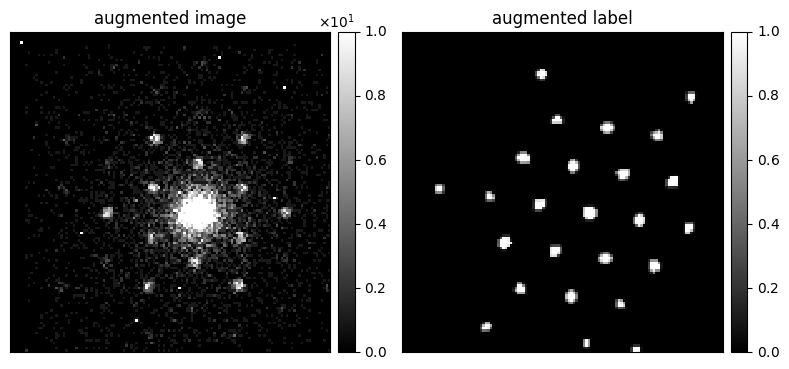

In [6]:
params_augment = {
    "add_bkg":True, 
    "bkg_weight":[0.01, 0.05], # background intensity scaling
    "bkg_q":[0.01,0.1], # background cutoff offset
    "add_shot":True, 
    "e_dose":[1e4, 1e5], # total electron dose __per diffraction pattern__
    "add_shift":True,
    "xshift":[0,10], 
    "yshift":[0,10], 
    "add_ellipticity":True,
    "ellipticity_scale":[0., 0.15], # exx, eyy, and exy will be chosen from a normal distribution with this value as sigma
    "add_ellipticity_to_label":True,
    "add_salt_and_pepper":True,
    "salt_and_pepper":[0, 5e-4], # fraction of image to be (randomly) salt/peppered. currently has salt_v_pepper ratio = 1
    "add_scale": True,
    "scale_factor": [0.9,1.1], # set scale factor min to be 1 for magnification only 
    "add_blur": True, 
    "blur_sigma": [0, 1.5], # blur sigma in pixels 
    "add_flipshift": True,
    "free_rotation": True, # if False, will lock rotations to 90 degree increments
    "rotation_range": [-180, 180],
    "log_file":"../data/dp_augment.log",
    "rng":42, # None -> random 128 bit seed, either way will be recorded in the log
}

dp_aug = DPAugmentor(**params_augment, device='gpu') # device = "gpu" or "cpu"
dp_aug.print_params()

im = dset[0,0].array 
label =( im > im.mean()/5).astype(np.float32) # example classification labels

show_2d([im, label], cbar=True, upper_quantile=0.99, title=["input image", "input label"])

aug_im, aug_label = dp_aug.augment(im, label=label)

show_2d([aug_im, aug_label], cbar=True, upper_quantile=0.99, title=["augmented image", "augmented label"]   )


You can also augment stacks of images at once (but really it's just for looping through them, so it's not any faster or anything, just maybe more convenient)

(4, 128, 128)


augmenting:   0%|          | 0/4 [00:00<?, ?it/s]

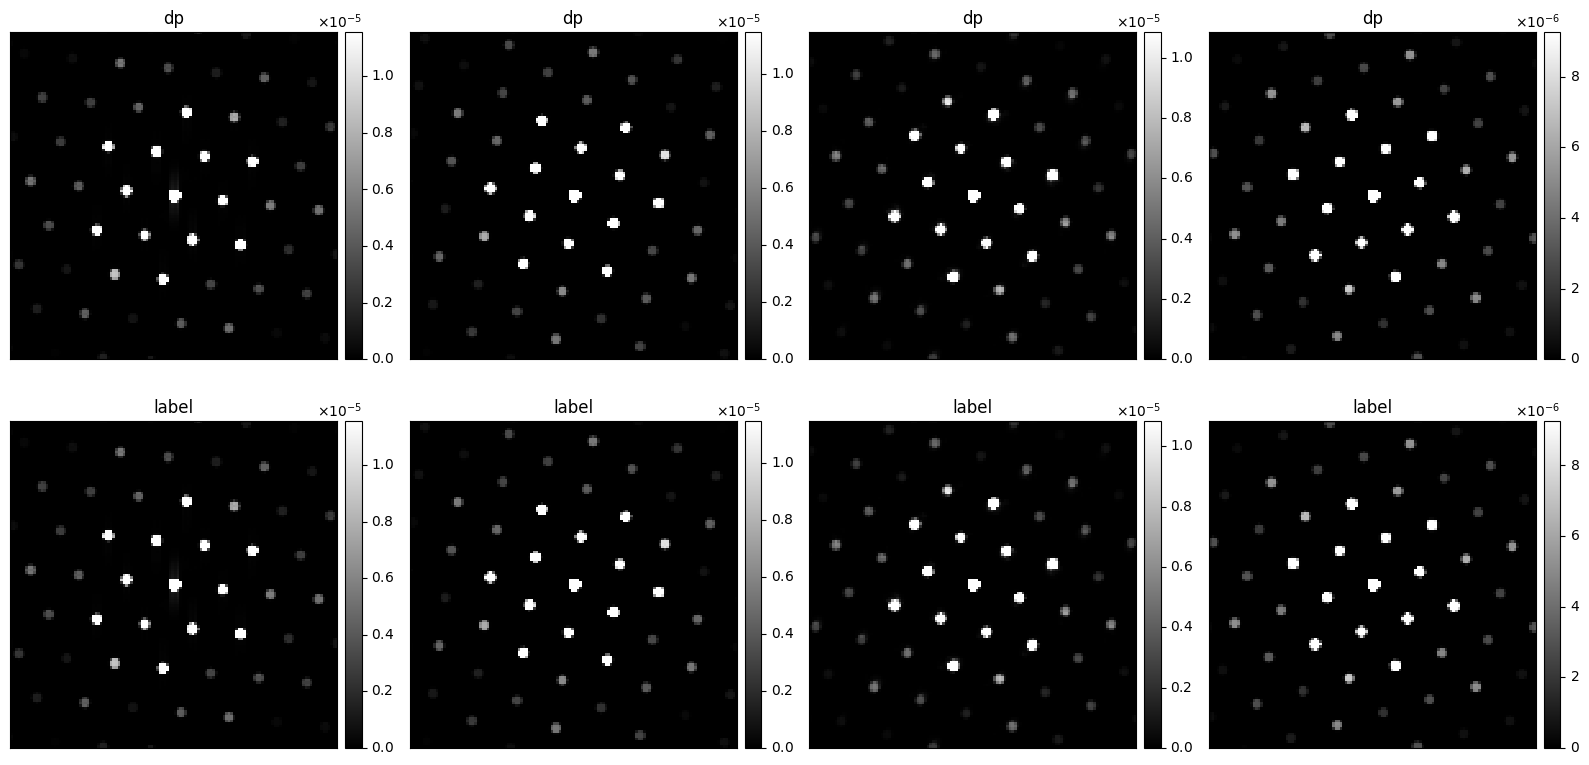

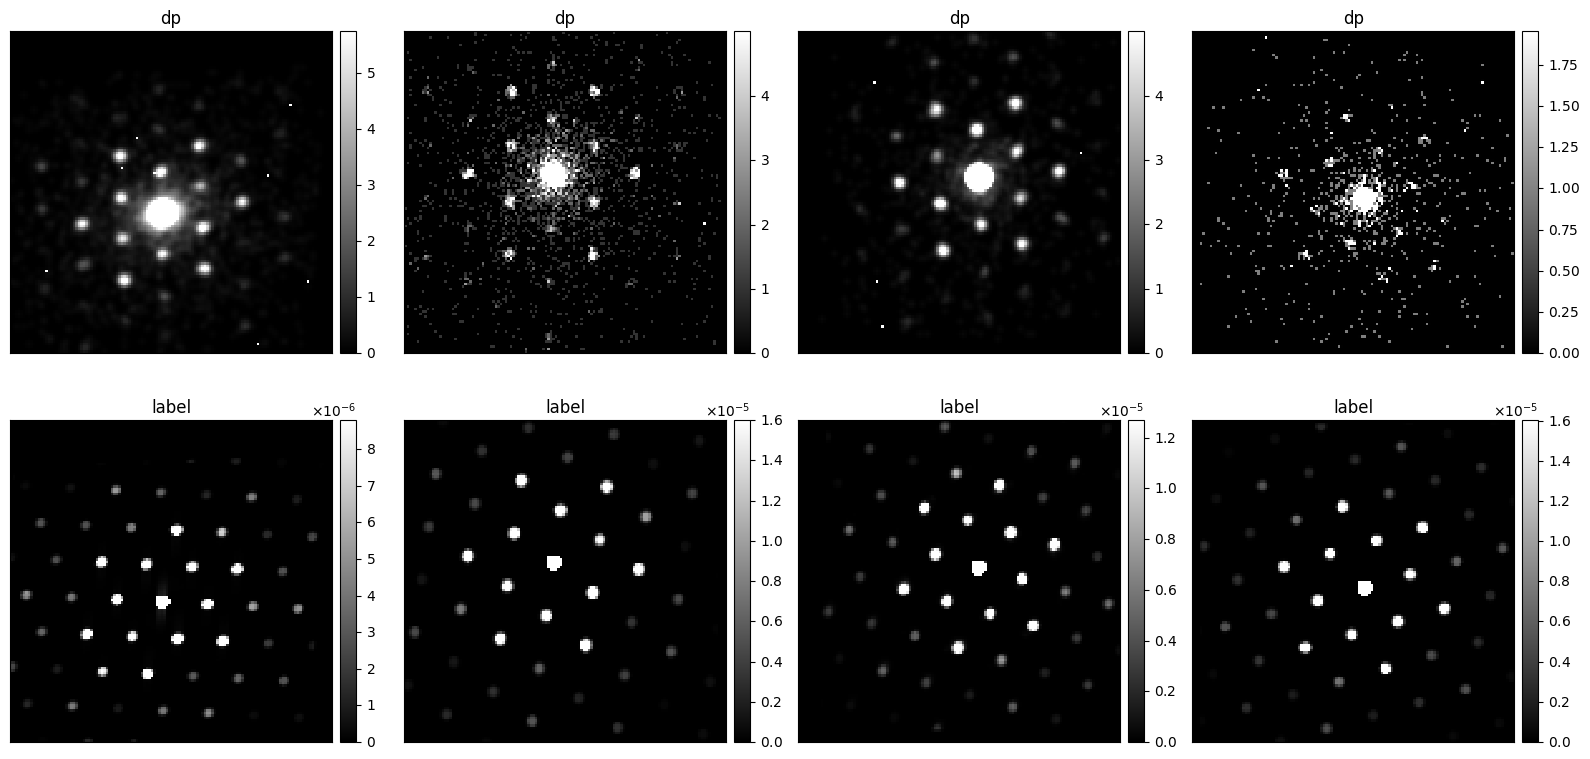

In [7]:
im = dset[::32, 64].array 
print(im.shape)
label = im.copy() # example autoencoder labels 
# label =( im > im.mean((-2,-1))[:,None,None]/10).astype(np.float32) # example classification labels


show_2d([[i for i in im], [i for i in label]], cbar=True, upper_quantile=0.99, title=[["dp" for _ in im ], ["label" for _ in label]])

aug_im, aug_label = dp_aug.augment(im, label=label)

show_2d([[i for i in aug_im], [i for i in aug_label]], cbar=True, upper_quantile=0.99, title=[["dp" for _ in im ], ["label" for _ in label]]);
